## Análise exploratória dos dados
<hr style="border:2px solid #0077b9;">

- Obtendo os dados através da BDQ.py
- Explorando os dados (seaborn)

## Obtendo os dados através da BDQ.py
<hr style="border:2px solid #0077b9;">

- Recuperar N focos de queimadas para cada região do Brasil
    - Para cada foco, obter valores de risco, precipitação, temperatura e umidade para o dia do evento

In [1]:
# Recuperar N focos de queimadas para cada região do Brasil
from bdq import bdq;
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display, HTML 
display(HTML("<style>.dataframe{font-size: 16px !important;}</style>"))

b = bdq(wfs="http://localhost:8080/geoserver-esensing/", wtss="http://localhost:7654")
# recupera 500 focos de cada regiao
N=500
fc_n , _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"], filter="regiao='N'", max_features=N, sort_by='rand')
fc_ne, _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"], filter="regiao='NE'", max_features=N, sort_by='rand')
fc_co, _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"],filter="regiao='CO'", max_features=N, sort_by='rand')
fc_se, _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"],filter="regiao='SE'", max_features=N, sort_by='rand')
fc_s , _ = b.feature_collection("esensing:focos_bra_2016", attributes=["timestamp","regiao","bioma"],filter="regiao='S'", max_features=N, sort_by='rand')

In [173]:
# Combinando todos os dados
focos = pd.concat([fc_n, fc_ne, fc_co, fc_se, fc_s], ignore_index=True)

# Salvando focos
#focos.to_pickle('focos.pkl')

# Mostrando amostra
display(fc.sample(n=5))

,bioma,coordinates,regiao,timestamp
1715,Mata Atlântica,"[-47.714, -23.001]",SE,2016-08-01T21:29:17Z
2342,Mata Atlântica,"[-50.474, -27.289]",S,2016-06-08T17:05:44Z
1991,Cerrado,"[-45.869, -16.638]",SE,2016-07-13T16:05:14Z
2269,Pampa,"[-51.165, -29.679]",S,2016-07-24T17:40:00Z
131,Cerrado,"[-48.423, -8.376]",N,2016-09-03T16:35:00Z


In [ ]:
# Para cada foco, obtem o valor de risco, precipitação, temperatura e umidade para o dia da ocorrência
import pickle
dados = None
for index, row in focos.iterrows():
    s_date = datetime.strptime(row['timestamp'], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m-%d")
    ts, ts_metadata = b.time_series("rpth", 
                                    ("risk","precipitation", "temperature", "humidity"), 
                                    row['coordinates'][1], row['coordinates'][0],
                                    start_date=s_date, 
                                    end_date=s_date)
    ts['bioma'] = row['bioma']
    ts['regiao'] = row['regiao']
    ts['timestamp'] = row['timestamp']
    if dados is None:
        dados = ts;
    else:
        dados = pd.concat([dados, ts],ignore_index=True)

# Salvando dados
#dados.to_pickle('dados.pkl')

In [10]:
# Carregando dados previamente salvos
import pickle
import pandas as pd

# Focos
focos = pd.read_pickle('focos.pkl')

# Risco, Temperatura, Umidade, Precipitação
dados = pd.read_pickle('dados.pkl')

In [11]:
dados.sample(n=5) 

,humidity,precipitation,risk,temperature,bioma,regiao,timestamp
249,0.428250,1.200532,0.135689,306.563385,Amazônia,N,2016-09-28T18:50:00Z
150,0.868787,0.000000,0.963731,304.901245,Amazônia,N,2016-12-04T16:12:00Z
1879,0.390336,0.000000,1.000000,303.163025,Cerrado,SE,2016-10-03T17:10:00Z
2441,0.611706,0.021181,0.653092,294.857941,Mata Atlântica,S,2016-08-16T17:10:00Z
2316,0.541552,0.000000,0.014847,292.929413,Mata Atlântica,S,2016-08-24T16:20:00Z


## Explorando os dados
<hr style="border:2px solid #0077b9;">
- Explorar dados
    - Todo o Brasil
    - Por região (N, NE, CO, SE e S)
    - Por bioma (Amazônia, Caatinga, Cerrado, Pantanal, Mata Atlântica e Pampa)
    - Por estação (Primavera, Verão, Outono e Inverno)

### Todo o Brasil
<hr style="border:2px solid #0077b9;">

In [12]:
# Visão geral dos dados
dados.describe()

,humidity,precipitation,risk,temperature
count,2500.000000,2500.000000,2.500000e+03,2500.000000
mean,0.393418,0.240373,2.193226e+35,303.259091
std,0.168406,1.349106,1.462609e+36,5.183475
min,0.112702,0.000000,3.000701e-07,281.210266
25%,0.263692,0.000000,6.098014e-01,300.751740
50%,0.359624,0.000000,1.000000e+00,304.640213
75%,0.489772,0.000000,1.000000e+00,306.974297
max,0.990000,19.725483,9.969210e+36,313.932220


In [13]:
# Arrumando os dados

# Removendo linhas com missing data
dados = dados[dados['risk']<=1]

# reordenando os dados
dados = dados[["risk", "precipitation", "humidity", "temperature", "bioma", "regiao", "timestamp"]]

# Convertendo temperatura de Kelvin para Celsius
dados["temperature"] = dados["temperature"]-273.15

# Convertendo para data
dados['timestamp'] = pd.to_datetime(dados['timestamp'])  

dados.describe()

,risk,precipitation,humidity,temperature
count,2.445000e+03,2445.000000,2445.000000,2445.000000
mean,7.832390e-01,0.240514,0.389986,30.203471
std,3.354363e-01,1.354300,0.166902,5.165241
min,3.000701e-07,0.000000,0.112702,8.060266
25%,5.830897e-01,0.000000,0.262603,27.765741
50%,1.000000e+00,0.000000,0.355428,31.578058
75%,1.000000e+00,0.000000,0.484281,33.872186
max,1.000000e+00,19.725483,0.990000,40.782220


In [14]:
# importando e configurando módulos de plotagem
import seaborn as sns
import numpy as np
from IPython.display import display, HTML 
from matplotlib import pyplot as plt
%matplotlib inline 

fig_size = (16,5)
palette=sns.diverging_palette(10, 240,  as_cmap=True)

siglas = ["N ", "NE", "CO", "SE", "S "]
titulos = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]

palette=sns.diverging_palette(240, 10,  as_cmap=True)

# Configurando slides
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/vconrado/anaconda3/envs/ds/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "scroll": True,
              "start_slideshow_at": "selected",
})

{u'scroll': True, u'start_slideshow_at': 'selected'}

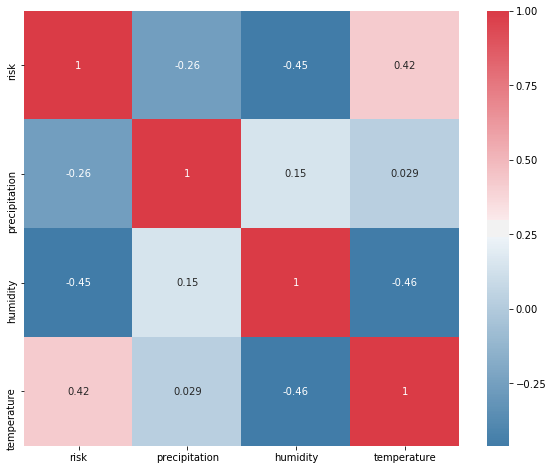

In [16]:
# Gerando matrix de correlação
f, ax = plt.subplots(figsize=(10, 8))
corr = dados.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
            square=True, ax=ax, annot=True)

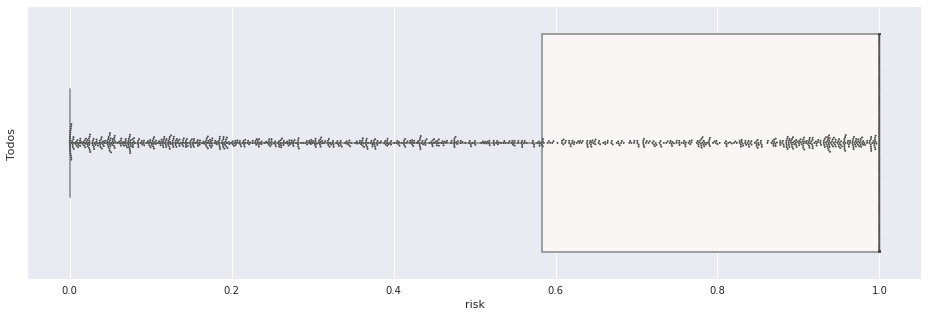

In [118]:
# Boxplot de todos os dados
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", data=dados, palette="vlag")
sns.swarmplot(x="risk", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True) 
ax.set(ylabel="Todos")
sns.despine(trim=True, left=True)

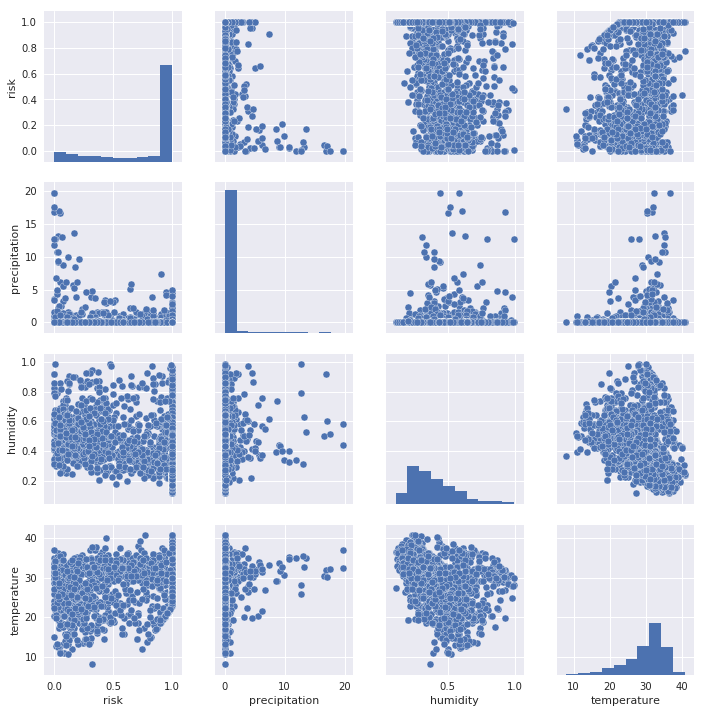

In [119]:
# Gerando scatterplot matrix
sns.pairplot(dados)

### Por região
<hr style="border:2px solid #0077b9;">
- N, NE, CO, SE e S

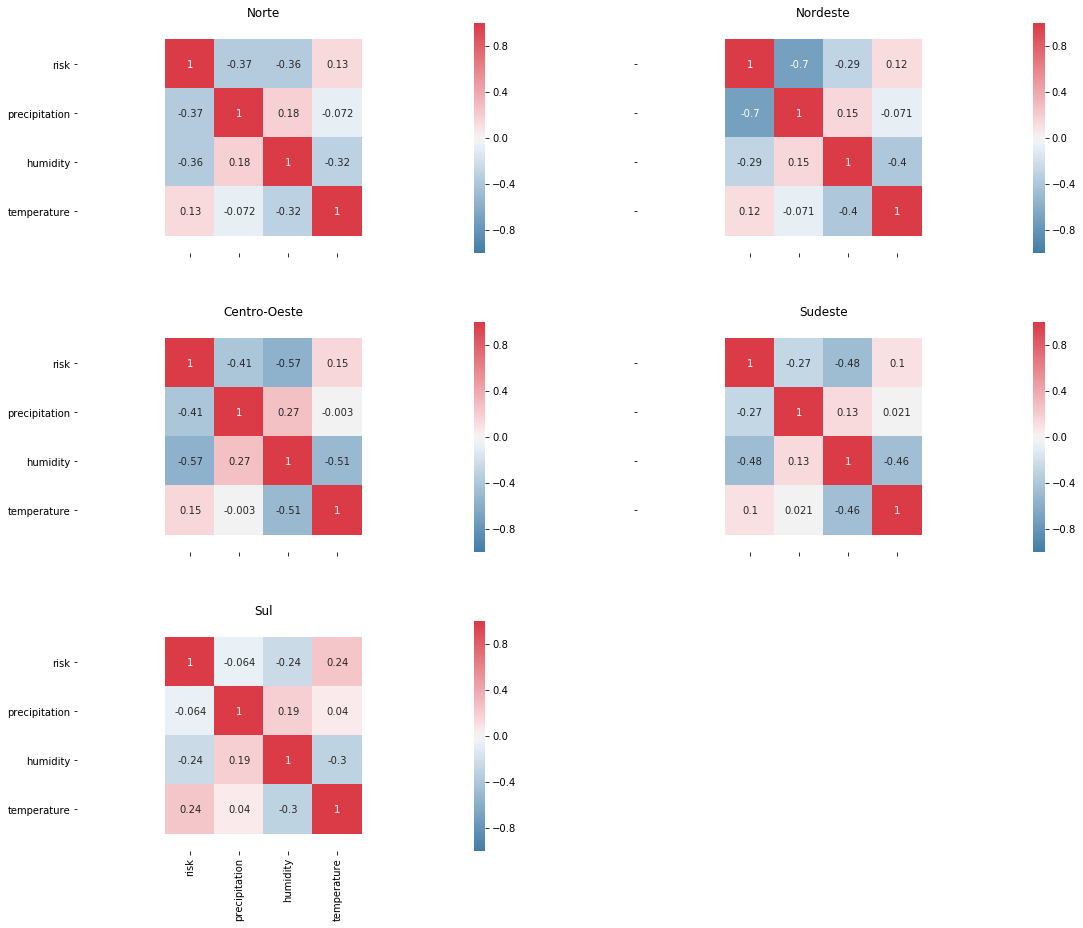

In [17]:
# Gerando matrix de correlação para cada região

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 5):
    corr = dados[dados['regiao'] == siglas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
                square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(titulos[i])

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.3, top=3, right=2.5)

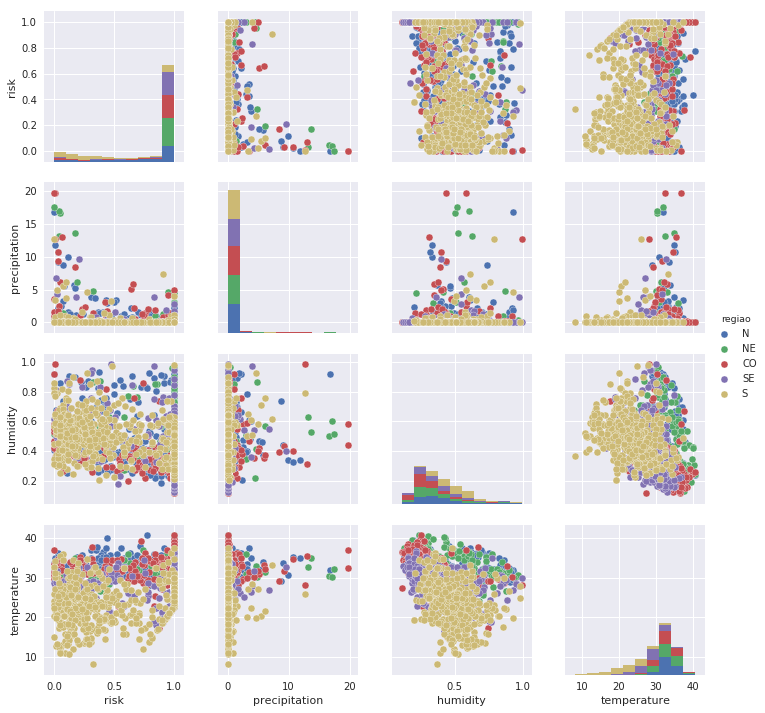

In [121]:
# Gerando scatterplot matrix por região
sns.pairplot(dados, hue="regiao")

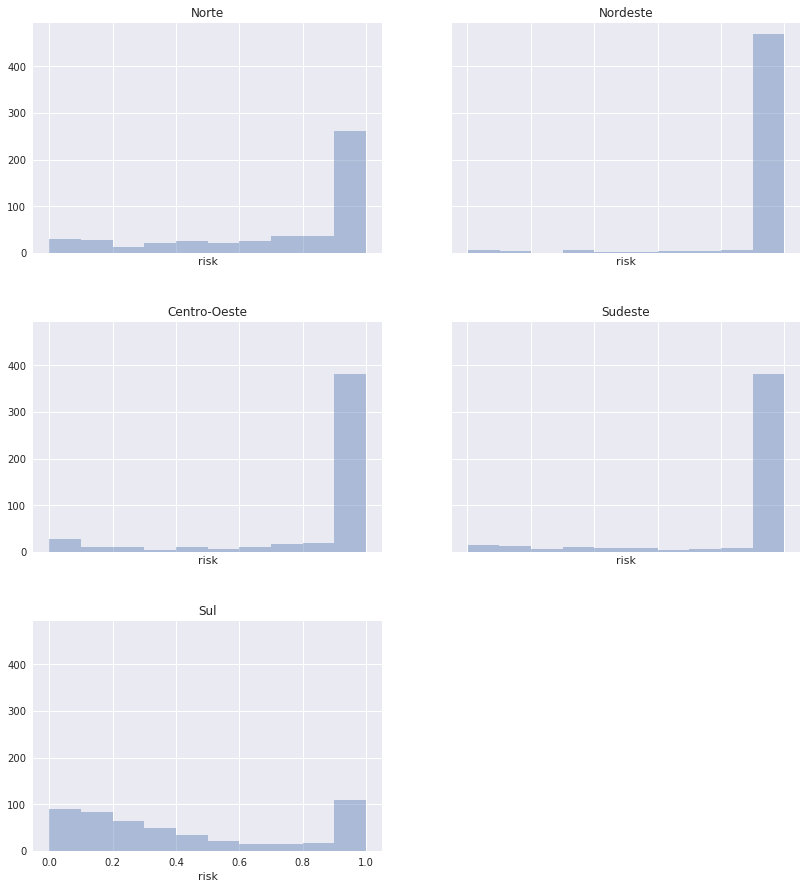

In [122]:
# Histogramas para cada região
from scipy import stats, integrate
sns.set(color_codes=True)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 5):
    sns.distplot(dados[dados['regiao'] == siglas[i]]["risk"], ax=ax[i], kde=False, bins=10);
    ax[i].set_title(titulos[i])

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.3, top=3, right=1.9)

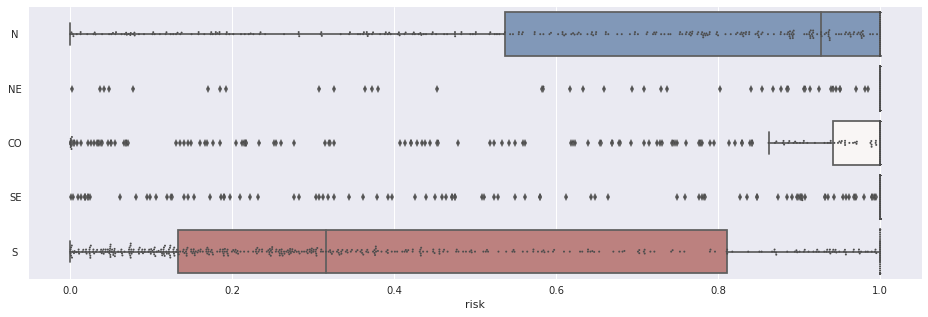

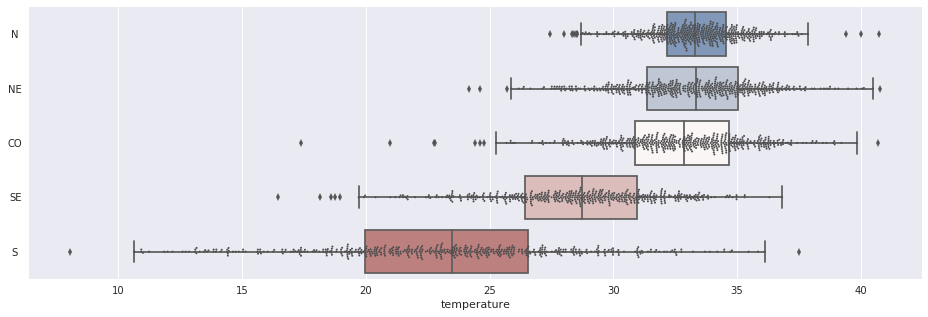

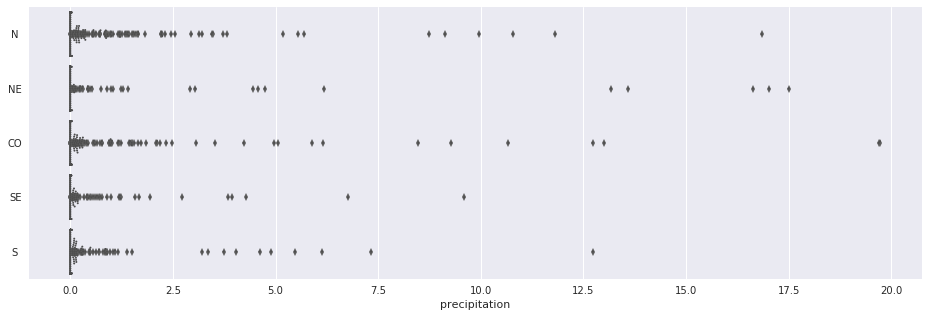

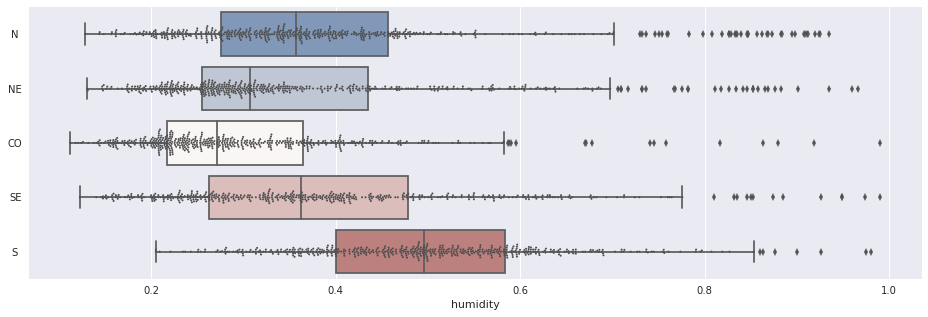

In [123]:
# Gerando boxplot para (risco, temperatura, precipitação, umidade) por região

for var in ("risk", "temperature", "precipitation", "humidity"):
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(ax=ax, x=var,  y="regiao", data=dados, palette="vlag")
    sns.swarmplot(x=var, y="regiao", data=dados, size=2, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)

### Por bioma
<hr style="border:2px solid #0077b9;">
- Amazônia, Caatinga, Cerrado, Pantanal, Mata Atlântica e Pampa

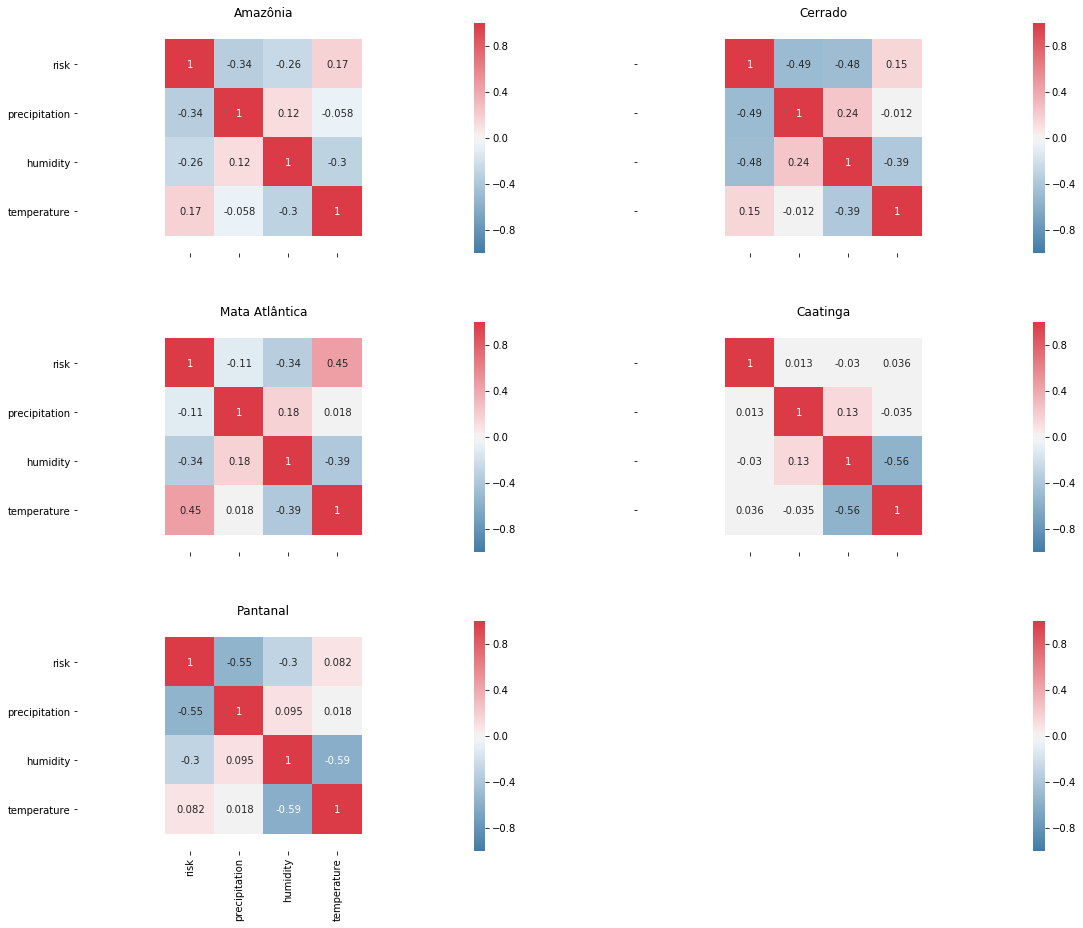

In [18]:
biomas = dados['bioma'].unique()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in xrange(0, 6):
    corr = dados[dados['bioma']==biomas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
                square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(biomas[i])

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.3, top=3, right=2.5)

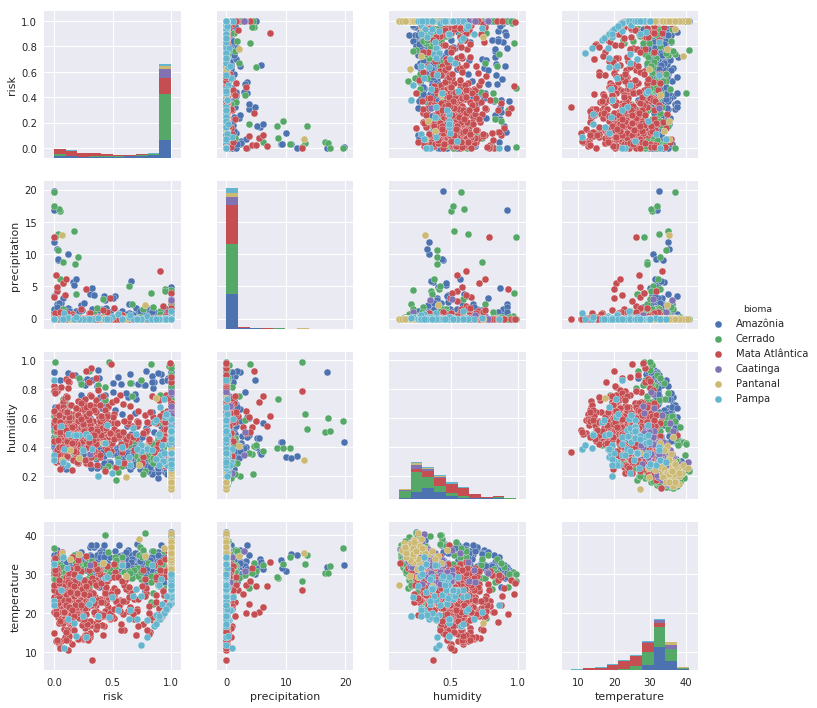

In [125]:
# Gerando scatterplot matrix por bioma
sns.pairplot(dados, hue="bioma")

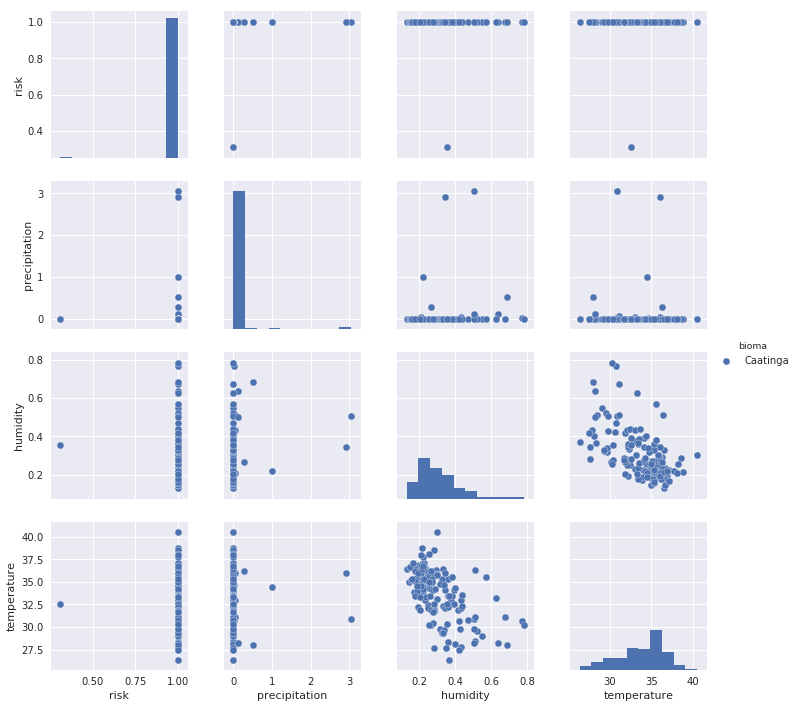

In [126]:
# Olhando os dados da Caatinga
sns.pairplot(dados[dados['bioma']=="Caatinga"], hue="bioma")

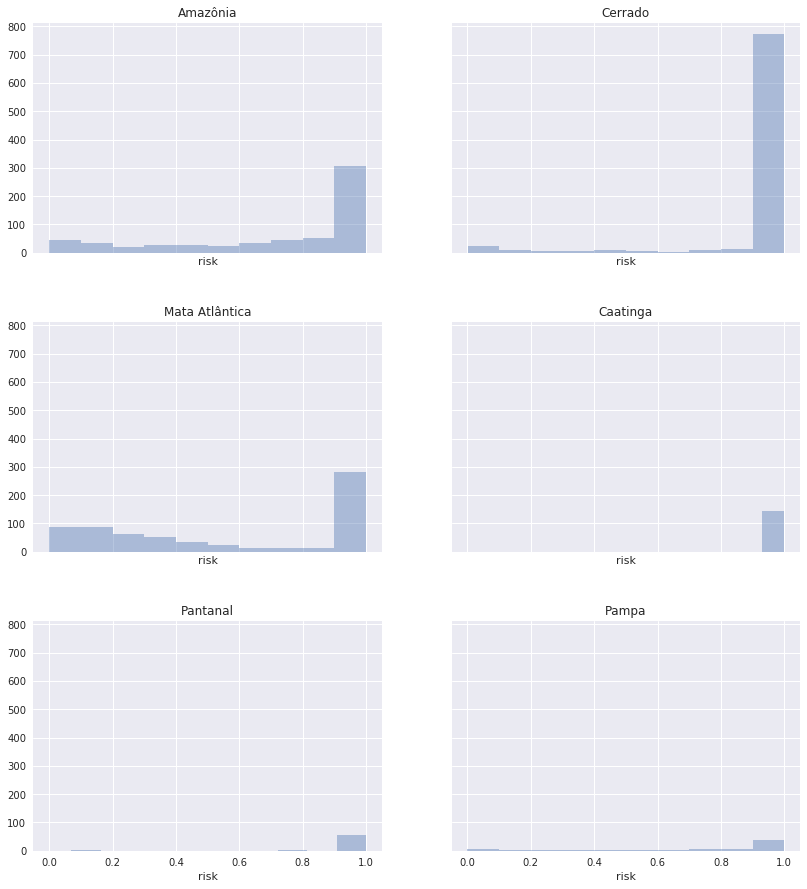

In [127]:
# Histogramas para cada região

from scipy import stats, integrate
sns.set(color_codes=True)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2 , sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in xrange(0, 6):
    sns.distplot(dados[dados['bioma']==biomas[i]]["risk"], ax=ax[i], kde=False, rug=False, bins=10);
    ax[i].set_title(biomas[i])

plt.subplots_adjust(hspace=0.3, top=3, right=1.9)

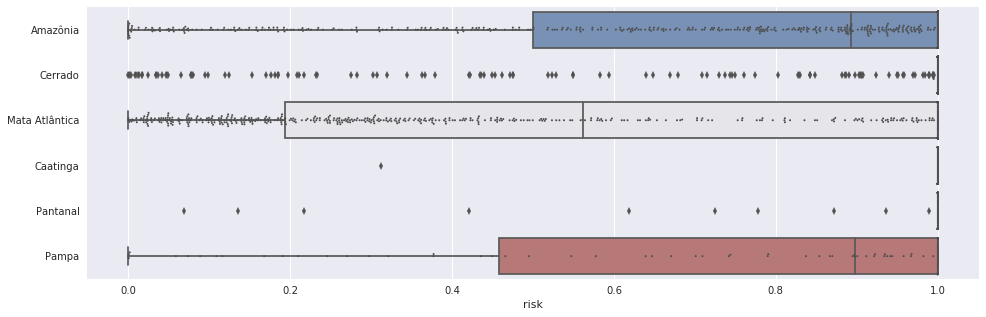

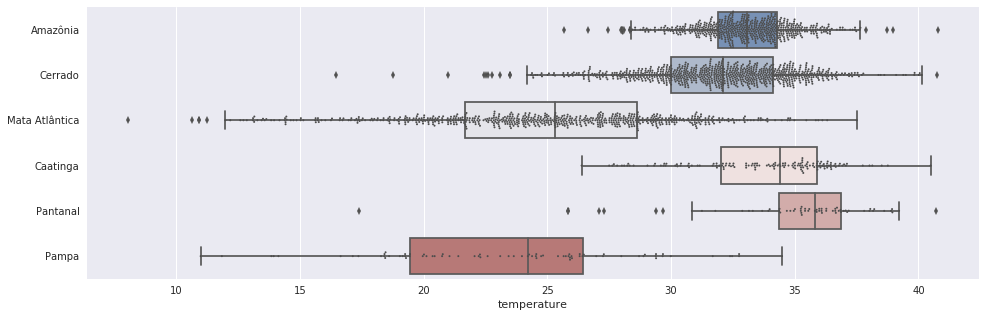

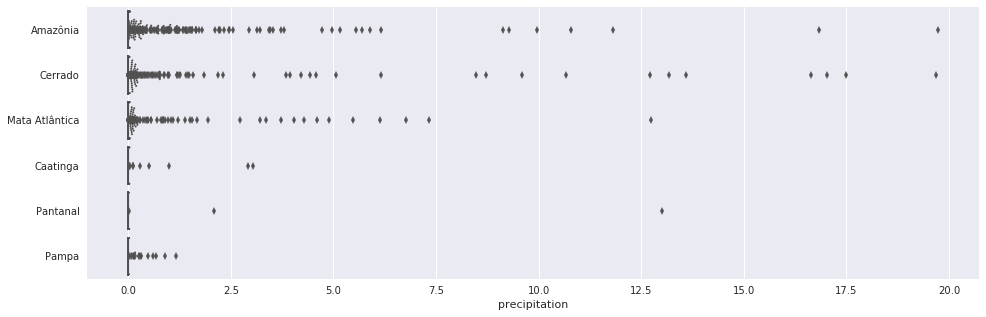

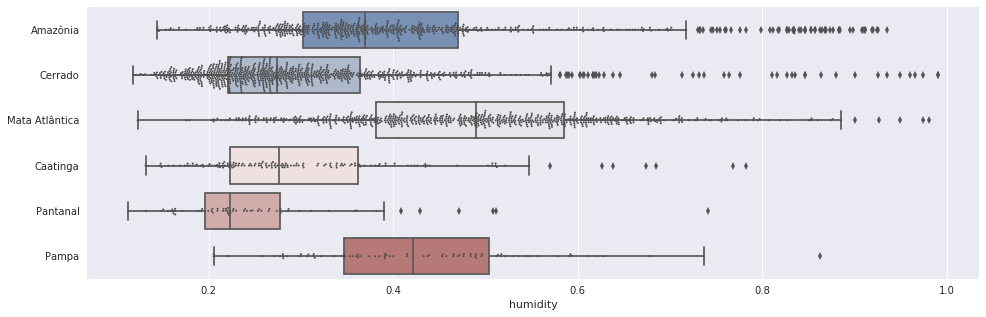

In [128]:
# Gerando boxplot para (risco, temperatura, precipitação, umidade) por bioma

for var in ("risk", "temperature", "precipitation", "humidity"):
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(ax=ax, x=var, y="bioma", data=dados, palette="vlag")
    sns.swarmplot(x=var, y="bioma", data=dados, size=2, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)

### Por estações
<hr style="border:2px solid #0077b9;">
- Primavera, Verão, Outono e Inverno

In [129]:
# Separando dados por estação

# períodos das estacoes no hemisfério sul
primavera = (dados['timestamp'] > '2016-09-23') & (dados['timestamp'] <= '2016-12-21')
verao = (dados['timestamp'] > '2016-12-21') | ( (dados['timestamp'] >= '2016-01-01') & (dados['timestamp'] < '2016-03-21') )
outono = (dados['timestamp'] > '2016-03-21') & (dados['timestamp'] <= '2016-06-20')
inverno = (dados['timestamp'] > '2016-06-20') & (dados['timestamp'] <= '2016-09-23')

# Criando coluna estacao
dados['estacao']=''
dados.loc[primavera, 'estacao']="primavera"
dados.loc[verao, 'estacao']="verao"
dados.loc[outono,'estacao']="outono"
dados.loc[inverno, 'estacao']='inverno'

# Contado por grupo de risco e por estação
dados.filter(items=["risk", "estacao"])\
     .groupby(["estacao",pd.cut(dados["risk"], np.arange(0, 1+.25, .25))])\
     .count().rename(columns={'risk':'Total'})

Total
estacao   risk              
inverno   (0.0, 0.25]    143
          (0.25, 0.5]     88
          (0.5, 0.75]     76
          (0.75, 1.0]   1066
outono    (0.0, 0.25]     32
          (0.25, 0.5]     31
          (0.5, 0.75]     13
          (0.75, 1.0]     82
primavera (0.0, 0.25]    124
          (0.25, 0.5]     81
          (0.5, 0.75]     49
          (0.75, 1.0]    514
verao     (0.0, 0.25]     47
          (0.25, 0.5]     17
          (0.5, 0.75]     12
          (0.75, 1.0]     70

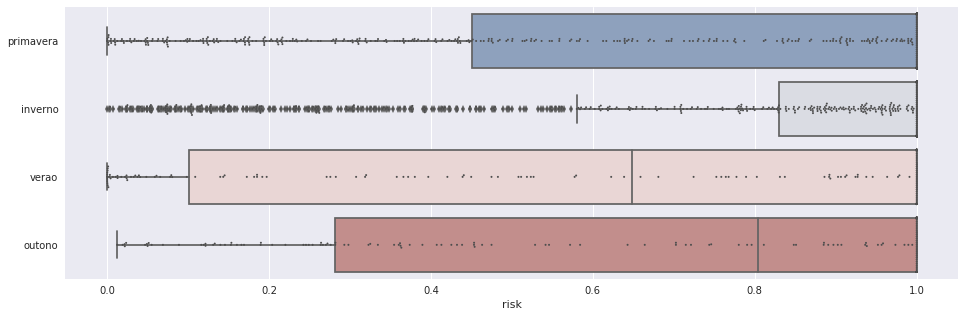

In [130]:
# Boxplot para Estação-Risco
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", y="estacao", data=dados, palette="vlag")
sns.swarmplot(x="risk", y="estacao", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

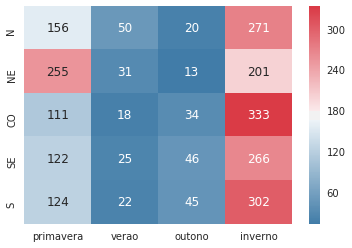

In [131]:
# Ocorrências por Região-Estação

estacao_regiao=pd.DataFrame(index=("N ", "NE", "CO", "SE", "S "))
for estacao in ("primavera", "verao", "outono", "inverno"): 
    for regiao in ("N ", "NE", "CO", "SE", "S "):
        estacao_regiao.set_value(regiao, estacao, len(dados.loc[ (dados['estacao']==estacao) & (dados['regiao']==regiao)]))

sns.heatmap(estacao_regiao, cmap=palette, annot=True,  fmt='g')

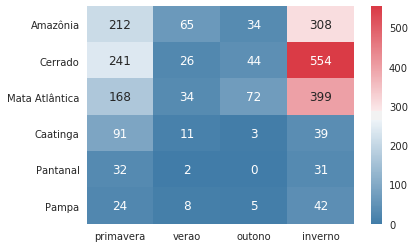

In [132]:
# Ocorrências por Bioma-Estação

estacao_bioma=pd.DataFrame(index=dados['bioma'].unique())
for estacao in ("primavera", "verao", "outono", "inverno"): 
    for bioma in dados['bioma'].unique():
        estacao_bioma.set_value(bioma,estacao, len(dados.loc[ (dados['estacao']==estacao) & (dados['bioma']==bioma)]))

sns.heatmap(estacao_bioma, cmap=palette, annot=True, fmt='g')

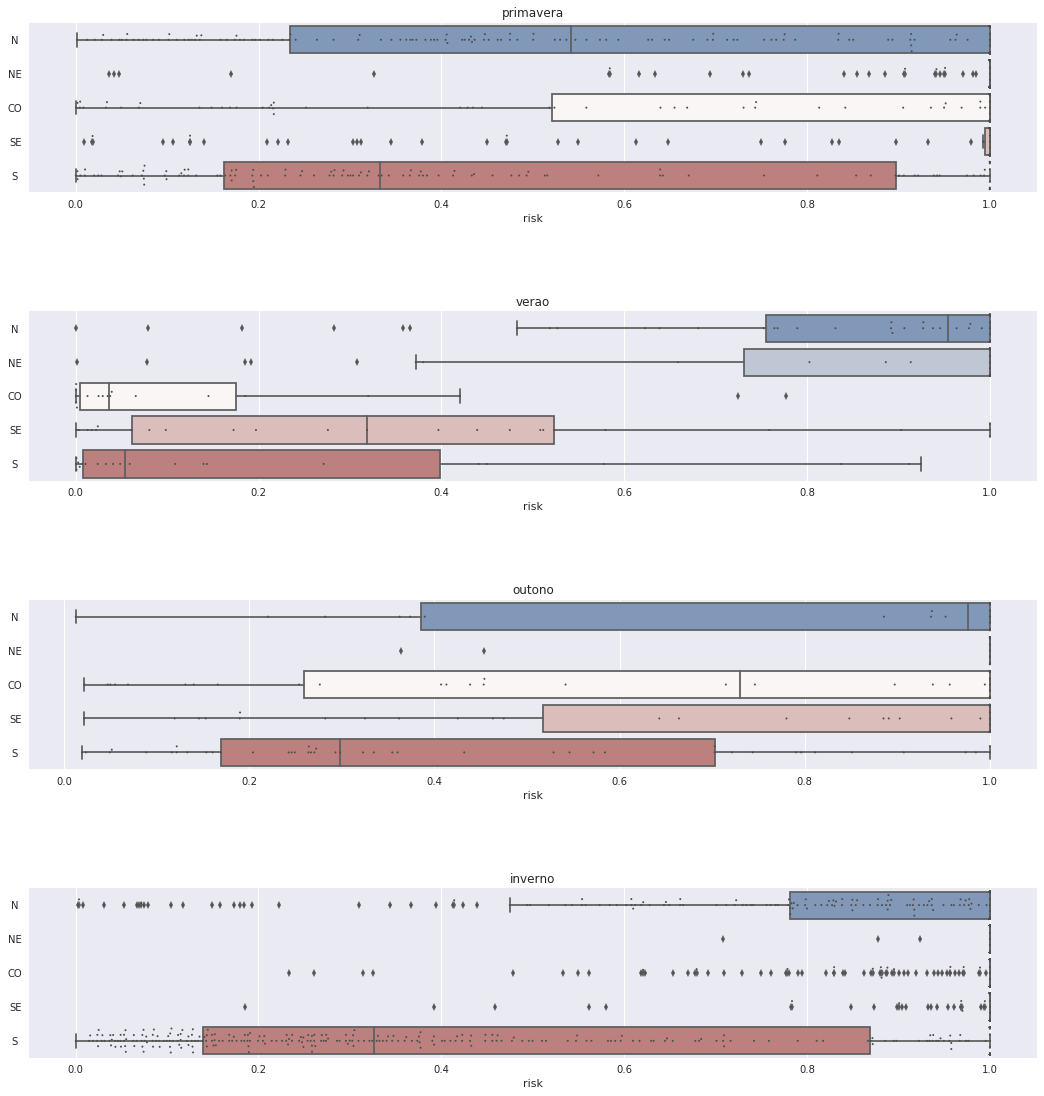

In [133]:
# Boxplot Região-Estação
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=fig_size)
ax = [ax1, ax2, ax3, ax4]
for estacao,i in zip(("primavera", "verao", "outono", "inverno"), xrange(0,5)): 
    sns.boxplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao] , palette="vlag", ax=ax[i])
    sns.swarmplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax[i])
    ax[i].xaxis.grid(True)
    ax[i].set(ylabel="")
    sns.despine(trim=True, left=True)
    ax[i].set_title(estacao)
plt.subplots_adjust(hspace=0.7, top=3, right=1)

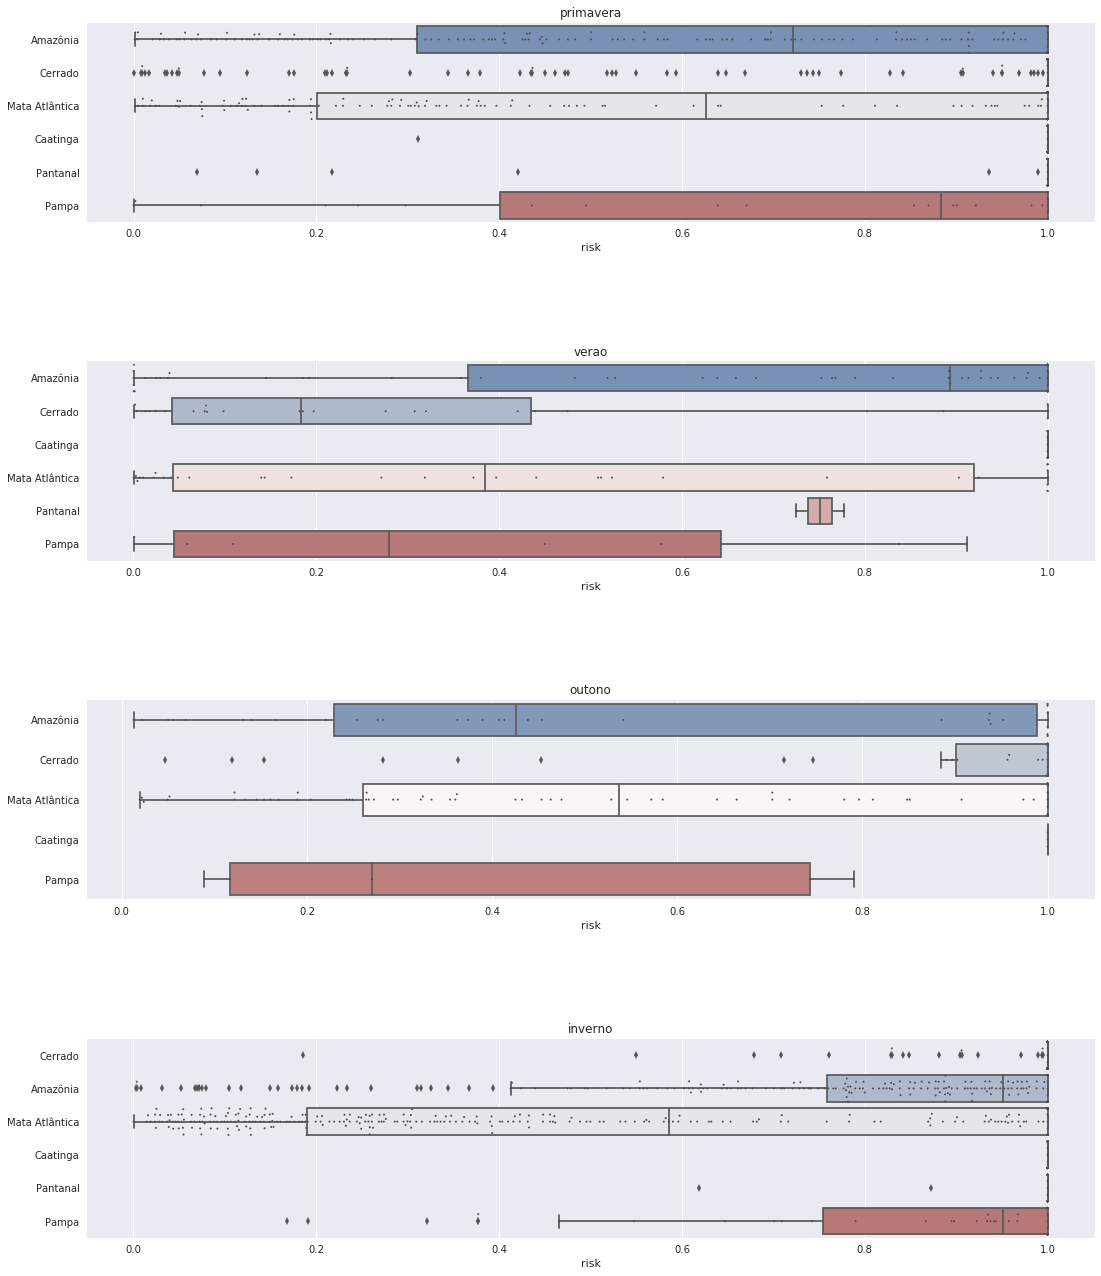

In [134]:
# Boxplot Bioma-Estação

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=fig_size)
ax = [ax1, ax2, ax3, ax4]
for estacao,i in zip(("primavera", "verao", "outono", "inverno"), xrange(0,5)): 
    sns.boxplot(x="risk", y="bioma", data=dados.loc[dados['estacao']==estacao] , palette="vlag", ax=ax[i])
    sns.swarmplot(x="risk", y="bioma", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax[i])
    ax[i].xaxis.grid(True)
    ax[i].set(ylabel="")
    sns.despine(trim=True, left=True)
    ax[i].set_title(estacao)
plt.subplots_adjust(hspace=0.7, top=3.5, right=1)

## Considerações
<hr style="border:2px solid #0077b9;">

### Quanto à análise dos dados
<hr style="border:2px solid #0077b9;">

- **Para uma melhor análise, deve-se considerar situações de risco alto e sem ocorrência de foco;**
- **Amostragem foi feita por região;**
- A relação entre o risco e o foco de queimada não é homogênea nas regiões, biomas ou estações do ano;
- Por região, o índice aparentemente funciona melhor para NE, CO e SE;
- Por bioma, o índice aparentemente funciona melhor para Cerrado, Caatinga e Pantanal;
    - Coerente regiões vs Bioma
- Por estação, o índice aparentemente funciona melhor no Inverno

### Quanto à infraestrutura e a disponibilização dos dados
<hr style="border:2px solid #0077b9;">

- Dependendo do volume de dados e forma de acesso, o processamento deve ser realizado junto aos dados
    - Arquitetura de referência [e-sensing](link)
- WTSS
   - Suportar requisições por lotes
   - Requisitar dados pelo valor (risco = X ou faixa)
- Novos dados
    - Disponibilizar dados de "Não focos"
    - Disponibilizar outros anos 

## Próximos passos
<hr style="border:2px solid #0077b9;">
- Avaliar dados de risco = 1 e não foco ('falso positivo')
- Responder a pergunta: "Se o risco (região/bioma/estação) é R qual a probabilidade de ocorrência de focos de queimada?"
- Remapear o risco (região/bioma/estação) para classes considerando a probabilidade obtida.

## Links
<hr style="border:2px solid #0077b9;">


- **Trabalho da disciplina**: [https://github.com/vconrado/cap-386](https://github.com/vconrado/cap-386)
- **Interleaver**: [http://github.com/vconrado/interleaver](http://github.com/vconrado/interleaver)
- **Chunkfier**: [http://github.com/vconrado/chunkfier](http://github.com/vconrado/chunkfier)
- **BDQ.py**: [http://github.com/vconrado/bdq.py/](http://github.com/vconrado/bdq.py/)
- WTSS.py: [https://github.com/e-sensing/wtss.py](https://github.com/e-sensing/wtss.py)
- tiff-to-raw: [https://github.com/tfogal/tiff-to-raw](https://github.com/tfogal/tiff-to-raw)